In [1]:
import pandas as pd 

data = pd.read_csv("../data/preprocessed_data.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,total_acidity,sugar_acidity_ratio,sulfur_ratio,alcohol_sugar_interaction,quality_class
0,7.4,0.70,0.00,1.064711,0.073250,2.484907,3.555348,0.9978,3.51,0.444686,2.341806,5,8.10,0.228534,0.323529,2.937043,1
1,7.8,0.88,0.00,1.280934,0.093490,3.258097,4.219508,0.9968,3.20,0.518794,2.379546,5,8.68,0.287682,0.373134,3.276390,1
2,7.8,0.76,0.04,1.193922,0.088011,2.772589,4.007333,0.9970,3.26,0.500775,2.379546,5,8.56,0.258412,0.277778,3.158701,1
3,11.2,0.28,0.56,1.064711,0.072321,2.890372,4.110874,0.9980,3.16,0.457425,2.379546,6,11.48,0.156698,0.283333,2.976549,1
4,7.4,0.66,0.00,1.029619,0.072321,2.639057,3.713572,0.9978,3.51,0.444686,2.341806,5,8.06,0.217723,0.325000,2.885917,1


## Splitting the data

In [2]:
X = data.drop(["quality", "quality_class"], axis=1)
y = data["quality_class"]
X.shape, y.shape

((1359, 15), (1359,))

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1019, 15), (340, 15), (1019,), (340,))

## Applying Scaler

In [4]:
from sklearn.preprocessing import StandardScaler

sclr = StandardScaler()

X_train_s = sclr.fit_transform(X_train)
X_test_s = sclr.transform(X_test)

## Applying SMOTE

In [5]:
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state=1)

X_train_final, y_train_final = smt.fit_resample(X_train_s, y_train)

## Finding the model

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

models = {"Random Forest": RandomForestClassifier(random_state=1, class_weight="balanced"),
          "KNN": KNeighborsClassifier(),
          "SGD": SGDClassifier(random_state=1)}

def evaluate_model(X_train_s, X_test_s, y_train, y_test):
    for label, model in models.items():
        model.fit(X_train_s, y_train)
        y_pred = model.predict(X_test_s)
        
        print(f"--- {label} Model Metrics ---")
        print(f"Acc Score: {accuracy_score(y_test, y_pred)}")
        print(f"CLF Report: {classification_report(y_test, y_pred)}")

In [7]:
evaluate_model(X_train_final, X_test_s, y_train_final, y_test)

--- Random Forest Model Metrics ---
Acc Score: 0.8205882352941176
CLF Report:               precision    recall  f1-score   support

           0       0.43      0.56      0.49        16
           1       0.90      0.88      0.89       278
           2       0.53      0.54      0.54        46

    accuracy                           0.82       340
   macro avg       0.62      0.66      0.64       340
weighted avg       0.83      0.82      0.82       340

--- KNN Model Metrics ---
Acc Score: 0.638235294117647
CLF Report:               precision    recall  f1-score   support

           0       0.16      0.56      0.24        16
           1       0.90      0.64      0.75       278
           2       0.36      0.65      0.46        46

    accuracy                           0.64       340
   macro avg       0.47      0.62      0.48       340
weighted avg       0.79      0.64      0.69       340

--- SGD Model Metrics ---
Acc Score: 0.6205882352941177
CLF Report:               precision  

## Improve the model

In [8]:
from sklearn.model_selection import GridSearchCV

grid = {"n_estimators": [100, 200, 500],
        "max_depth": [10, 20, None],
        "min_samples_leaf": [2, 4, 6],
        "min_samples_split": [2, 5],
        "class_weight": ["balanced", None]}

gsc = GridSearchCV(RandomForestClassifier(random_state=1), grid, cv=5, n_jobs=-1, verbose=True)
gsc.fit(X_train_final, y_train_final)

print(f"Best params: {gsc.best_params_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best params: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [9]:
model = RandomForestClassifier(class_weight="balanced", max_depth=20,
                               min_samples_leaf=2, min_samples_split=2,
                               n_estimators=100, random_state=1)
model.fit(X_train_final, y_train_final)

y_pred = model.predict(X_test_s)

print(classification_report(y_test, y_pred))
print(f"Score: {model.score(X_test_s, y_test)}")

              precision    recall  f1-score   support

           0       0.36      0.56      0.44        16
           1       0.90      0.86      0.88       278
           2       0.50      0.52      0.51        46

    accuracy                           0.80       340
   macro avg       0.59      0.65      0.61       340
weighted avg       0.82      0.80      0.81       340

Score: 0.8


## Visualizing the model

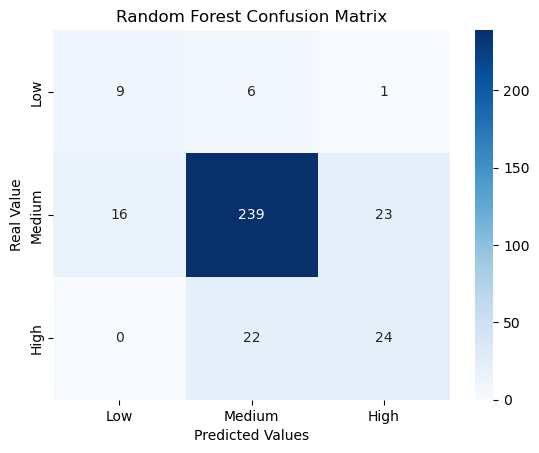

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Real Value")
plt.show()

## Feature importances

/var/folders/15/sxkbvdhs4759nsqxq03zn9kc0000gn/T/ipykernel_23100/1150790808.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importances", y="Features", data=feature_imp_df, palette="viridis")


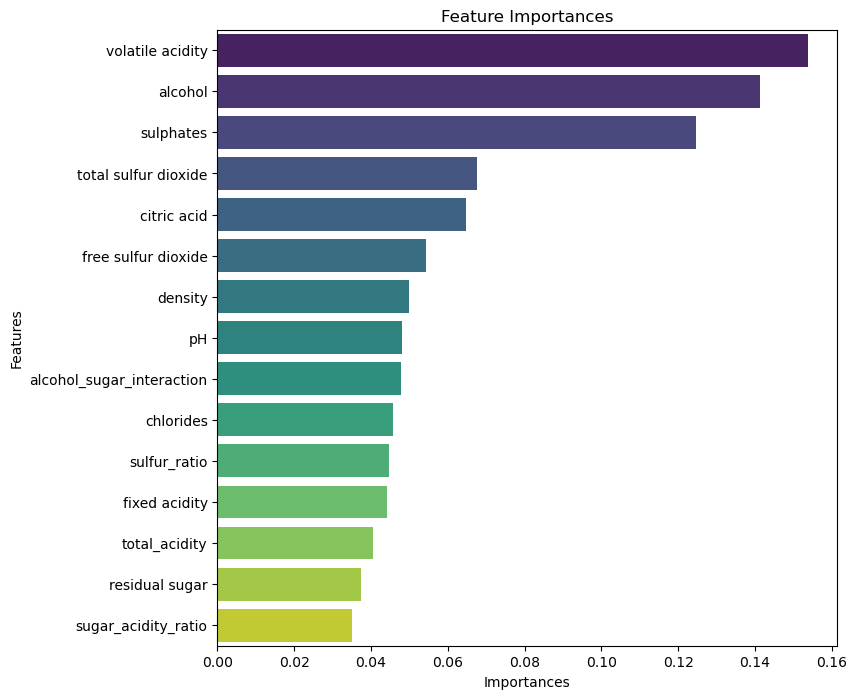

In [11]:
importances = model.feature_importances_
feature_names = X.columns

feature_imp_df = pd.DataFrame({"Features": feature_names, "Importances": importances})
feature_imp_df = feature_imp_df.sort_values(by="Importances", ascending=False)

plt.figure(figsize=(8, 8))
sns.barplot(x="Importances", y="Features", data=feature_imp_df, palette="viridis")
plt.title("Feature Importances")
plt.show()

## Saving the model

In [12]:
import joblib

joblib.dump(model, "wine_quality_rf_pred_model.pkl")
joblib.dump(sclr, "scaler.pkl")

['scaler.pkl']